In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

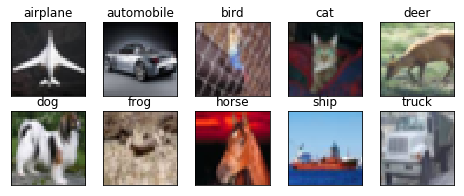

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [7]:
print(num_classes)

10


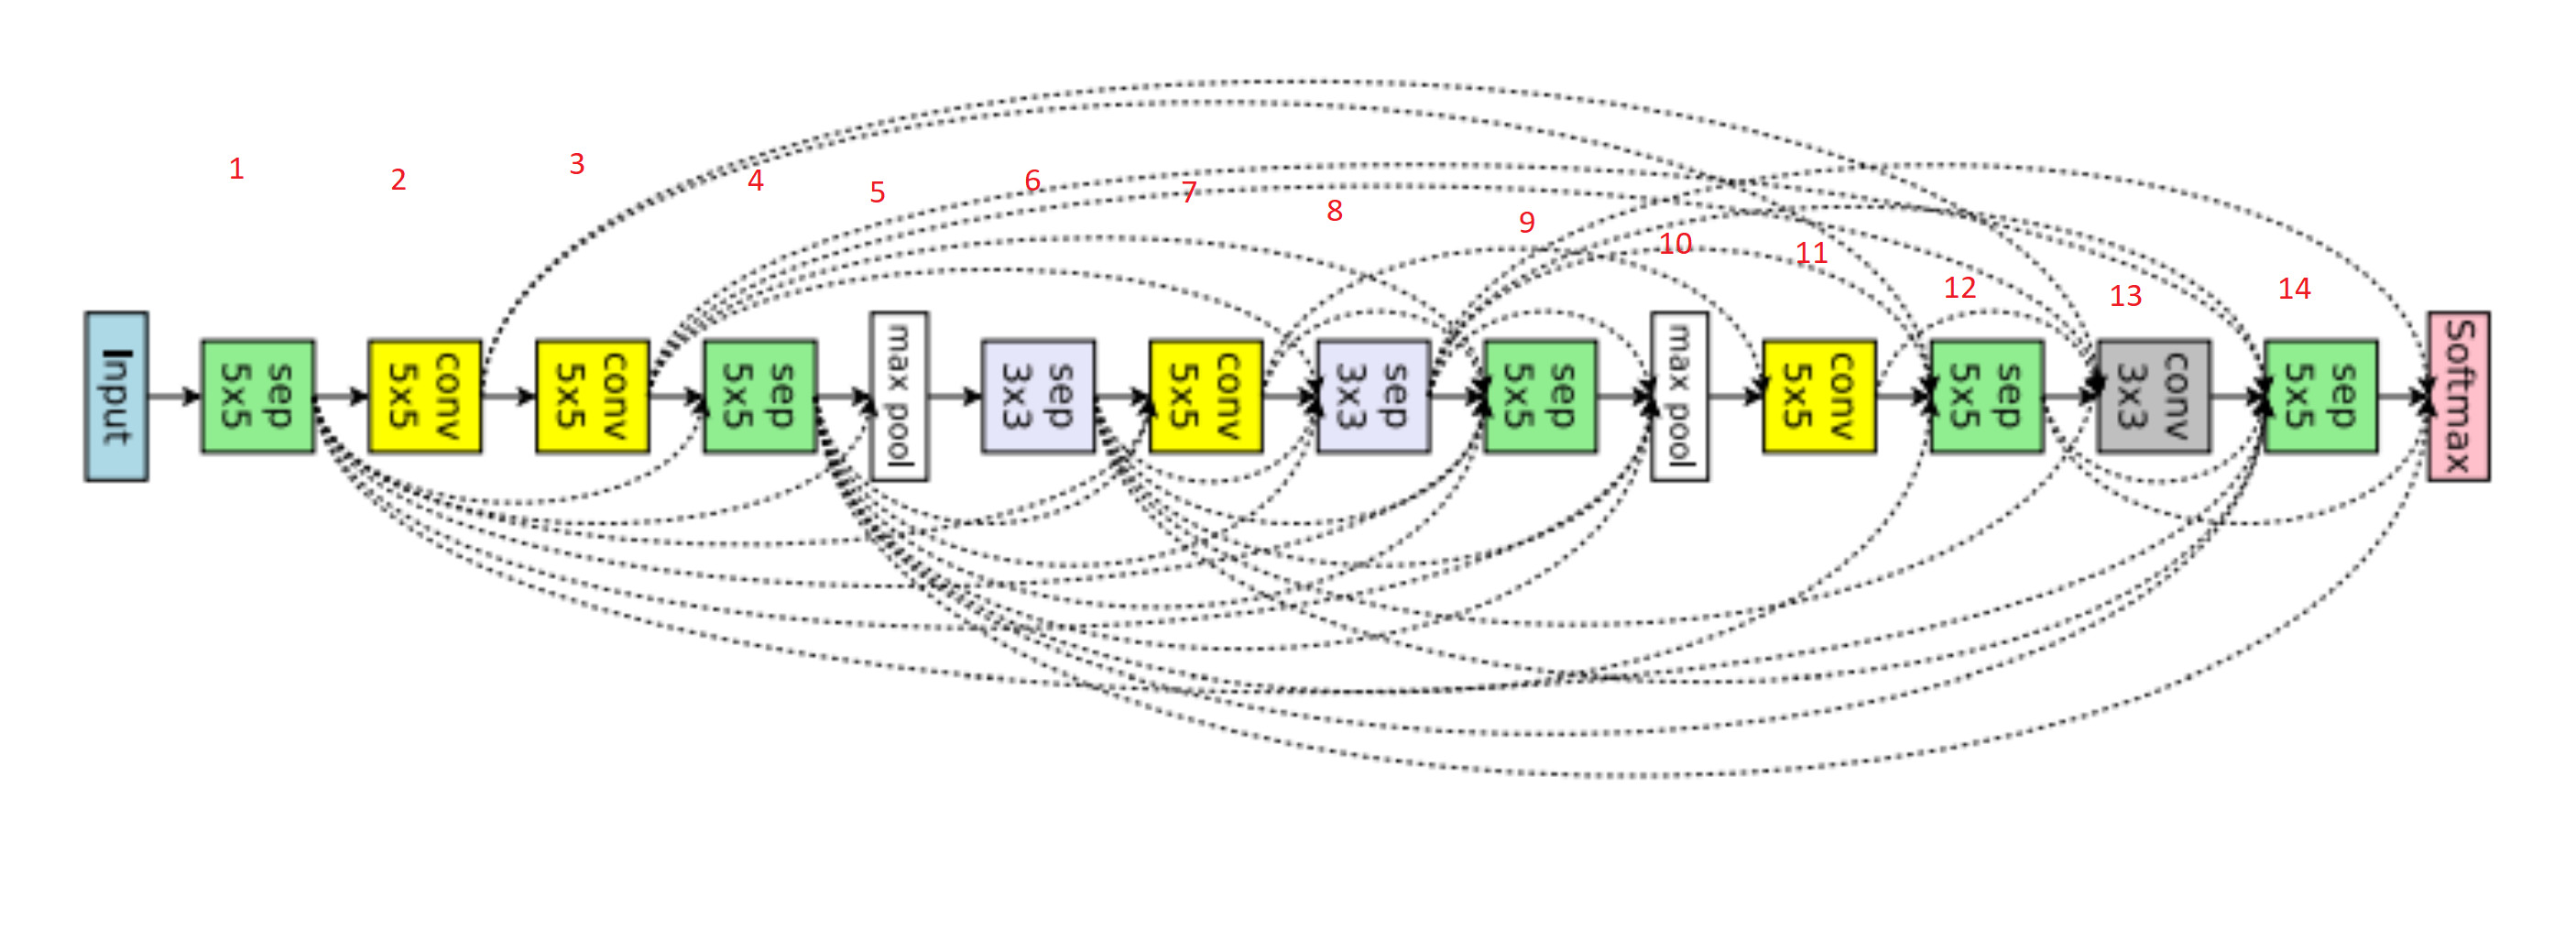

In [15]:
from IPython.display import Image, display
display(Image('CIFAR10.png', width=1000, height=300))
#<img src="CIFAR10.png" alt="Drawing" style="width: 200px;"/>

In [8]:
import keras
from keras import regularizers
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Input
from keras.utils import plot_model
from keras.models import Model
# from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate

visible = Input(shape=(32,32,3))

# 1. Depth wise separable Convolution - 5x5

conv1 = SeparableConv2D(16, (5,5), activation='relu')(visible)

# 2. Normal Convolution - 5x5

conv2 = Conv2D(32, (5,5), activation='relu')(conv1)

# 3. Normal Convolution - 5x5

conv3 = Conv2D(32, (5,5), activation='relu')(conv2)

# 4. Depth wise separable Convolution - 5x5

conv4 = SeparableConv2D(16, (5,5), activation='relu')(conv3)

L4_added_1 = concatenate([conv3, conv4])

L4_added_2 = concatenate([conv1, L4_added_1])

# 5. MaxPool

L5_pool_1 = MaxPooling2D(pool_size=(2, 2))(L4_added_2)

L5_added_1 = concatenate([conv1, L5_pool_1])

# 6. Depth wise separable Convolution - 3x3

conv6 = SeparableConv2D(16, (3,3), activation='relu')(L5_added_1)

# 7. Normal Convolution - 5x5

conv7 = Conv2D(32, (5,5), activation='relu')(conv6)

L7_added_1 = concatenate([L4_added_2, conv7])

L7_added_2 = concatenate([conv1, L7_added_1])

# 8. Depth wise separable Convolution - 3x3

conv8 = SeparableConv2D(16, (3,3), activation='relu')(L7_added_2)

L8_added_1 = concatenate([conv6, conv8])

L8_added_2 = concatenate([L4_added_2, L8_added_1])

L8_added_3 = concatenate([conv3, L8_added_2])

# 9. Depth wise separable Convolution - 5x5

conv9 = SeparableConv2D(16, (5,5), activation='relu')(L8_added_3)

L9_added_1 = concatenate([L7_added_2, conv9])

L9_added_2 = concatenate([conv6, L9_added_1])

L9_added_3 = concatenate([L4_added_2, L9_added_2])

L9_added_4 = concatenate([conv3, L9_added_3])

L9_added_5 = concatenate([conv1, L9_added_4])

# 10. MaxPool

L10_pool_1 = MaxPooling2D(pool_size=(2, 2))(L9_added_5)

L10_added_1 = concatenate([L8_added_3, L10_pool_1])

L10_added_2 = concatenate([conv6, L10_pool_1])

L10_added_3 = concatenate([L4_added_2, L10_added_2])

L10_added_4 = concatenate([conv1, L10_added_3])

# 11. Normal Convolution - 5x5

conv11 = Conv2D(32, (5,5), activation='relu')(L10_added_4)

L11_added_1 = concatenate([L7_added_2, conv10])

# 12. Depth wise separable Convolution - 5x5

conv12 = SeparableConv2D(16, (5,5), activation='relu')(L11_added_1)

L12_added_1 = concatenate([L8_added_3, conv12])

L12_added_2 = concatenate([conv2, L12_added_1])

L12_added_3 = concatenate([conv1, L12_added_2])

# 13. Normal Convolution - 3x3

conv13 = Conv2D(32, (3,3), activation='relu')(L12_added_3)

L13_added_1 = concatenate([L11_added_1, conv13])

L13_added_2 = concatenate([conv3, L13_added_1])

L13_added_3 = concatenate([conv2, L13_added_2])

L13_added_4 = concatenate([conv6, L13_added_3])

# 14. Depth wise separable Convolution - 5x5

conv14 = SeparableConv2D(16, (5,5), activation='relu')(L13_added_4)

L14_added_1 = concatenate([L8_added_3, conv14])

L14_added_2 = concatenate([conv3, L14_added_1])

L14_added_3 = concatenate([L12_added_3, L14_added_3])

L14_added_4 = concatenate([conv6, L14_added_3])

L14_added_5 = concatenate([L4_added_2, L14_added_4])

L14_added_6 = concatenate([, L14_added_5])

# 15. Softmax

conv15 = Activation('softmax')

L15_added_1 = concatenate([L8_added_3, conv15])

L15_added_2 = concatenate([L12_added_3, L15_added_1])

L15_added_3 = concatenate([L4_added_2, L15_added_2])


conv12 = Conv2D(num_classes, kernel_size=4, activation='relu')(L15_added_3) #1

flat = Flatten()(conv12)
output = Activation('softmax')(flat)
model = Model(inputs=visible, outputs=output)
 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#summarize layers
print(model.summary())

#plot graph
plot_model(model, to_file='model_plot.jpg', show_shapes=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 30, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 30, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)  

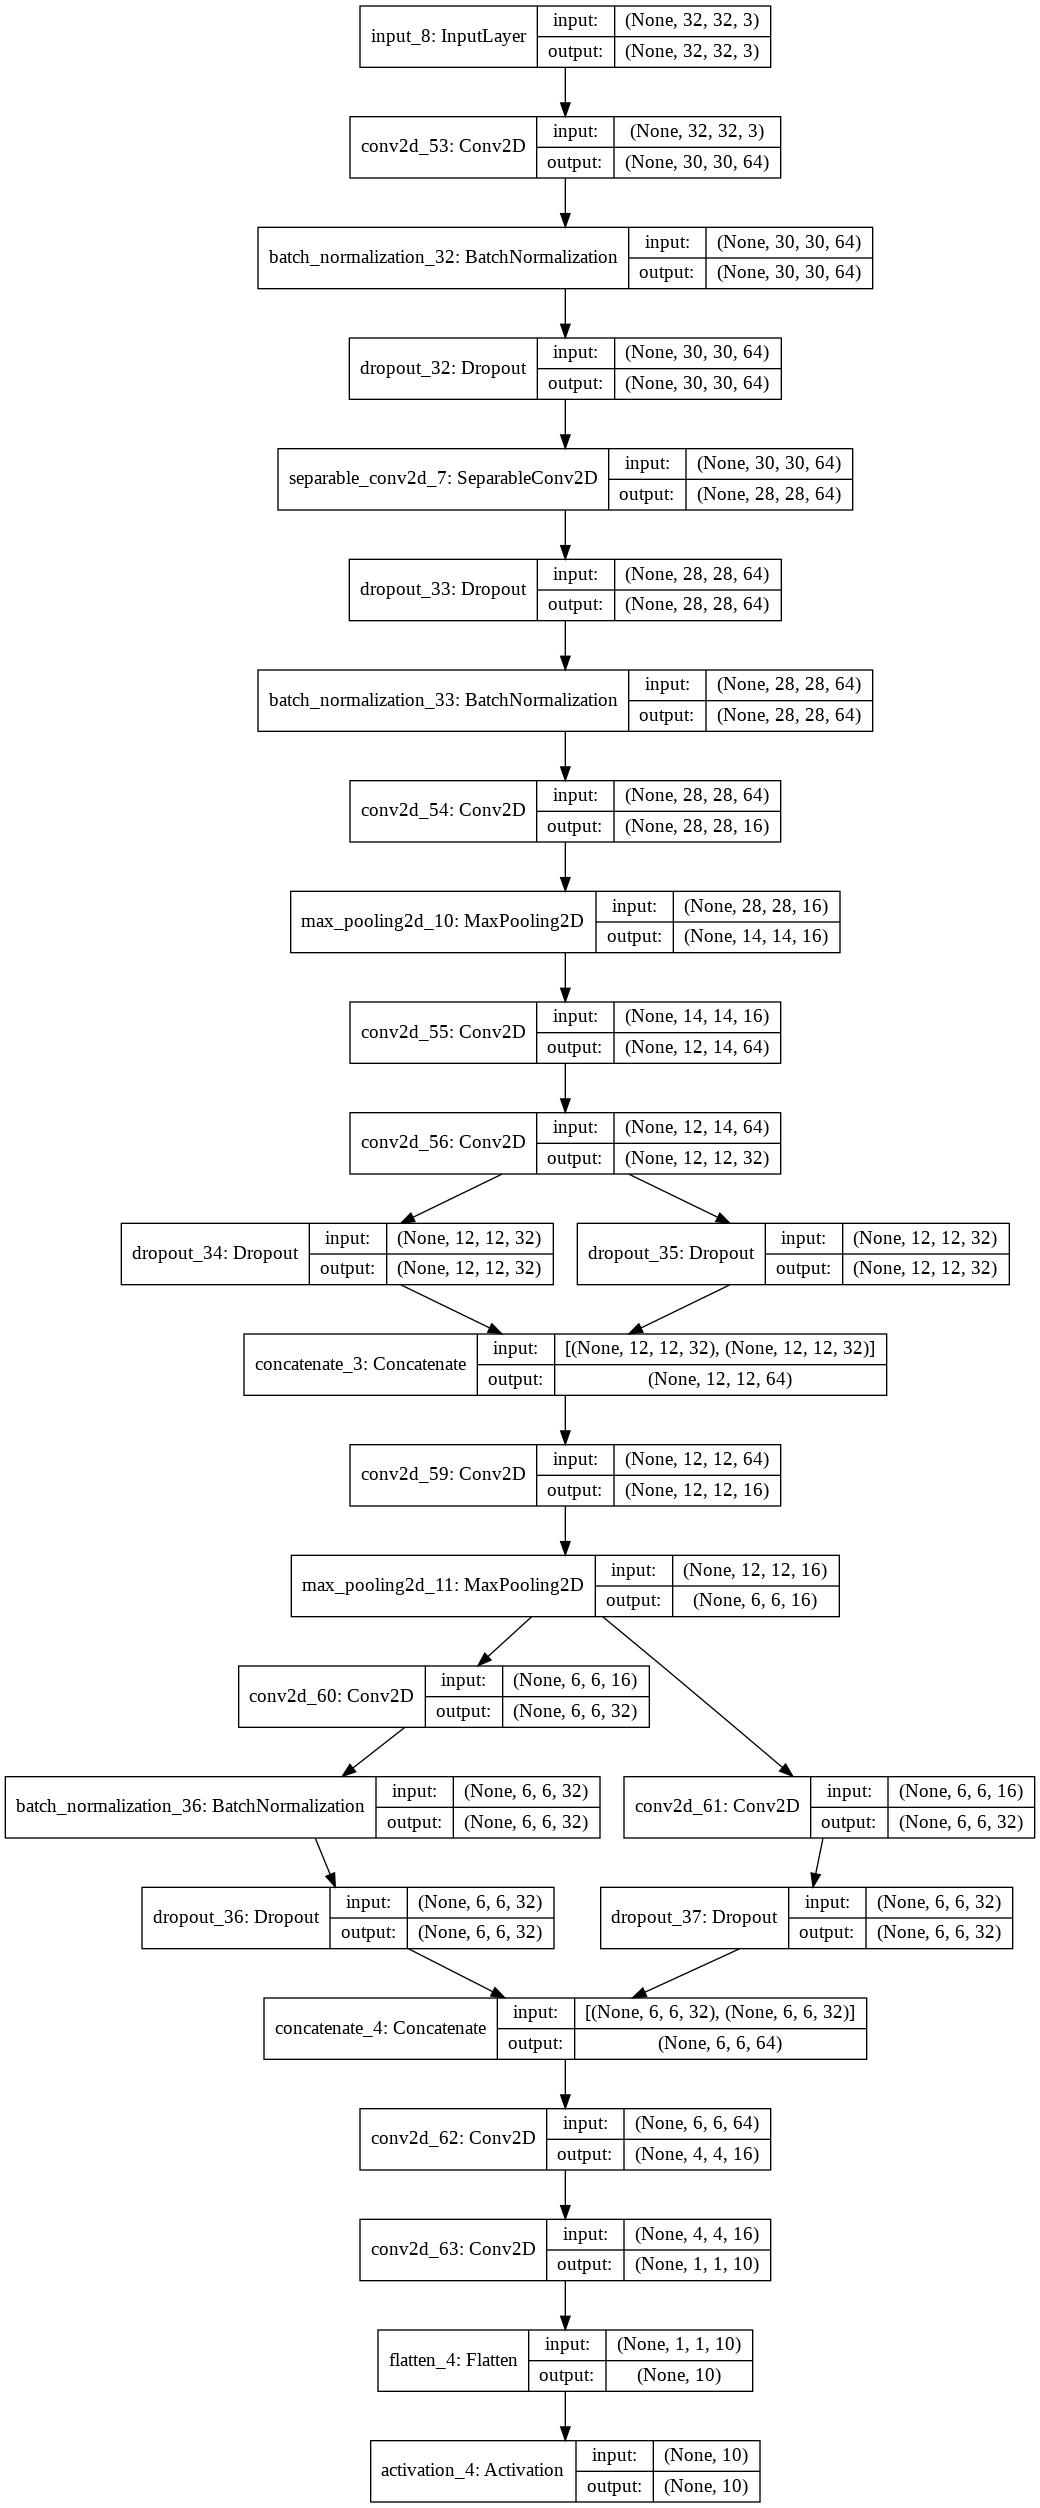

In [0]:
from IPython.display import Image, display
display(Image('model_plot.jpg'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=75)`


Epoch 1/75

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 19s 49ms/step - loss: 1.7624 - acc: 0.3600 - val_loss: 1.7541 - val_acc: 0.3919

Epoch 00001: val_acc improved from -inf to 0.39190, saving model to model_accuracy.best.hdf5
Epoch 2/75

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 16s 42ms/step - loss: 1.3002 - acc: 0.5301 - val_loss: 1.6039 - val_acc: 0.4524

Epoch 00002: val_acc improved from 0.39190 to 0.45240, saving model to model_accuracy.best.hdf5
Epoch 3/75

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 16s 42ms/step - loss: 1.1304 - acc: 0.5989 - val_loss: 1.1071 - val_acc: 0.6022

Epoch 00003: val_acc improved from 0.45240 to 0.60220, saving model to model_accuracy.best.hdf5
Epoch 4/75

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
390/390 [==================

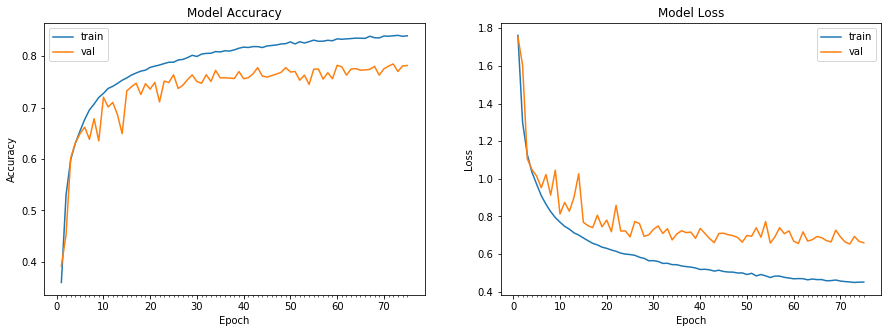

Accuracy on test data is: 78.18


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

# Accuracy on test data is: 83.88
# def scheduler(epoch, lr):
#   return round(0.003 * 1/(1 + 0.319 * epoch), 10)

# Accuracy on test data is: 83.48
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

filepath="model_accuracy.best.hdf5"

reduce_LR = LearningRateScheduler(lr_schedule, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 75, 
                                 validation_data = (test_features, test_labels), verbose=1,
                                callbacks=[reduce_LR, checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))